In [2]:
!python -V

Python 3.9.21


In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [7]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc_taxi_experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1747592152260, experiment_id='1', last_update_time=1747592152260, lifecycle_stage='active', name='nyc_taxi_experiment', tags={}>

In [8]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829628

/tmp/ipykernel_33014/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_33014/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


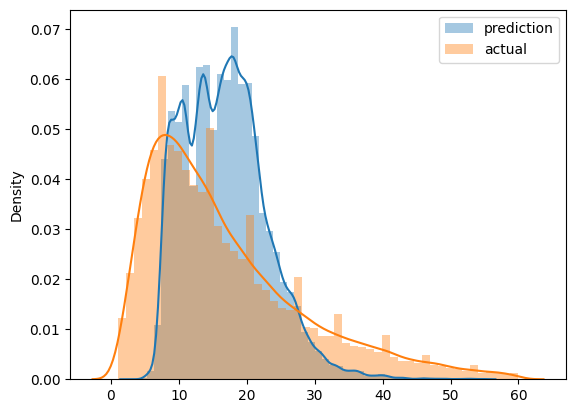

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715200888857

In [18]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [19]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Cristian")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)

    mlflow.log_metric("rmse", rmse)

In [20]:
import xgboost as xgb

In [21]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [24]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [35]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:08:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.32677                          
[1]	validation-rmse:10.57062                          
[2]	validation-rmse:9.92939                           
[3]	validation-rmse:9.38741                           
[4]	validation-rmse:8.93242                           
[5]	validation-rmse:8.55225                           
[6]	validation-rmse:8.23579                           
[7]	validation-rmse:7.97327                           
[8]	validation-rmse:7.75638                           
[9]	validation-rmse:7.57757                           
[10]	validation-rmse:7.42993                          
[11]	validation-rmse:7.30877                          
[12]	validation-rmse:7.20876                          
[13]	validation-rmse:7.12639                          
[14]	validation-rmse:7.05836                          
[15]	validation-rmse:7.00244                          
[16]	validation-rmse:6.95631                          
[17]	validation-rmse:6.91764                          
[18]	valid

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:09:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.63515                                                  
[1]	validation-rmse:11.11142                                                  
[2]	validation-rmse:10.63707                                                  
[3]	validation-rmse:10.21086                                                  
[4]	validation-rmse:9.82735                                                   
[5]	validation-rmse:9.48036                                                   
[6]	validation-rmse:9.17095                                                   
[7]	validation-rmse:8.89170                                                   
[8]	validation-rmse:8.64421                                                   
[9]	validation-rmse:8.42261                                                   
[10]	validation-rmse:8.22685                                                  
[11]	validation-rmse:8.05111                                                  
[12]	validation-rmse:7.89611                        

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:11:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.47314                                                      
[1]	validation-rmse:7.99101                                                      
[2]	validation-rmse:7.23678                                                      
[3]	validation-rmse:6.86004                                                      
[4]	validation-rmse:6.66896                                                      
[5]	validation-rmse:6.56791                                                      
[6]	validation-rmse:6.51096                                                      
[7]	validation-rmse:6.47333                                                      
[8]	validation-rmse:6.45251                                                      
[9]	validation-rmse:6.43668                                                      
[10]	validation-rmse:6.42691                                                     
[11]	validation-rmse:6.41978                                                     
[12]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:12:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.64920                                                    
[1]	validation-rmse:11.13556                                                    
[2]	validation-rmse:10.67003                                                    
[3]	validation-rmse:10.24837                                                    
[4]	validation-rmse:9.86681                                                     
[5]	validation-rmse:9.52188                                                     
[6]	validation-rmse:9.21112                                                     
[7]	validation-rmse:8.93168                                                     
[8]	validation-rmse:8.68092                                                     
[9]	validation-rmse:8.45527                                                     
[10]	validation-rmse:8.25346                                                    
[11]	validation-rmse:8.07377                                                    
[12]	validation-rmse:7.91323

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:13:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.77738                                                     
[1]	validation-rmse:6.60498                                                     
[2]	validation-rmse:6.58898                                                     
[3]	validation-rmse:6.58467                                                     
[4]	validation-rmse:6.57705                                                     
[5]	validation-rmse:6.56677                                                     
[6]	validation-rmse:6.55868                                                     
[7]	validation-rmse:6.54971                                                     
[8]	validation-rmse:6.53565                                                     
[9]	validation-rmse:6.52935                                                     
[10]	validation-rmse:6.52085                                                    
[11]	validation-rmse:6.51776                                                    
[12]	validation-rmse:6.51452

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77255                                                    
[1]	validation-rmse:11.36285                                                    
[2]	validation-rmse:10.98221                                                    
[3]	validation-rmse:10.62864                                                    
[4]	validation-rmse:10.30086                                                    
[5]	validation-rmse:9.99694                                                     
[6]	validation-rmse:9.71545                                                     
[7]	validation-rmse:9.45503                                                     
 10%|█         | 5/50 [05:40<51:02, 68.06s/trial, best loss: 40.285168968214094]


KeyboardInterrupt: 

In [25]:
params = {'learning_rate': 0.11277393085906096, 
            'max_depth': 14, 
            'min_child_weight': 15.8157406108412, 
            'objective': 'reg:linear',
            'reg_alpha': 0.04598357981155625, 
            'reg_lambda': 0.06746219585349657,
            'seed': 42
}

In [26]:
mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

2025/05/21 20:35:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2dea7ac6c1fb449ab7dafd18fda3d48c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:35:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.32677
[1]	validation-rmse:10.57062
[2]	validation-rmse:9.92939
[3]	validation-rmse:9.38741
[4]	validation-rmse:8.93242
[5]	validation-rmse:8.55225
[6]	validation-rmse:8.23579
[7]	validation-rmse:7.97327
[8]	validation-rmse:7.75638
[9]	validation-rmse:7.57757
[10]	validation-rmse:7.42993
[11]	validation-rmse:7.30877
[12]	validation-rmse:7.20876
[13]	validation-rmse:7.12639
[14]	validation-rmse:7.05836
[15]	validation-rmse:7.00244
[16]	validation-rmse:6.95631
[17]	validation-rmse:6.91764
[18]	validation-rmse:6.88520
[19]	validation-rmse:6.85847
[20]	validation-rmse:6.83502
[21]	validation-rmse:6.81527
[22]	validation-rmse:6.79838
[23]	validation-rmse:6.78407
[24]	validation-rmse:6.77204
[25]	validation-rmse:6.76186
[26]	validation-rmse:6.75306
[27]	validation-rmse:6.74513
[28]	validation-rmse:6.73862
[29]	validation-rmse:6.73229
[30]	validation-rmse:6.72718
[31]	validation-rmse:6.72229
[32]	validation-rmse:6.71830
[33]	validation-rmse:6.71446
[34]	validation-rmse:6

2025/05/21 20:36:28 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/05/21 20:36:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:36:28] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/05/21 20:36:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
